# Guía 2

## Importación de modulos y definición de funciones

In [2]:
import os
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import mne
from scipy import signal
import operator
from IPython.display import display, clear_output

def get_indexes(stim_labels, stim_code):
	indexes = []
	for i in range(len(stim_labels)):
		if stim_labels[i] == stim_code:
			indexes.append(i)
	return indexes

def mean_channel(data, indexes):
	channels = {}
	for channel in range(len(data[0])):
		canal = []
		for sample in range(len(data[0][channel])):
			samples = []
			for i in indexes:
				samples.append(data[i][channel][sample])
			canal.append(np.mean(samples))
		channels[channel] = canal
	return channels

def butter_bandpass_filter(data, frecuencias, sampling_freq, order, axis):
    frecuencias = [frecuencias[i]/(sampling_freq/2) for i in range(len(frecuencias))]
    b, a = signal.butter(order, frecuencias, btype='band')
    y = signal.filtfilt(b, a, data, axis = axis, padlen = None)
    return y

def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))


## PCA

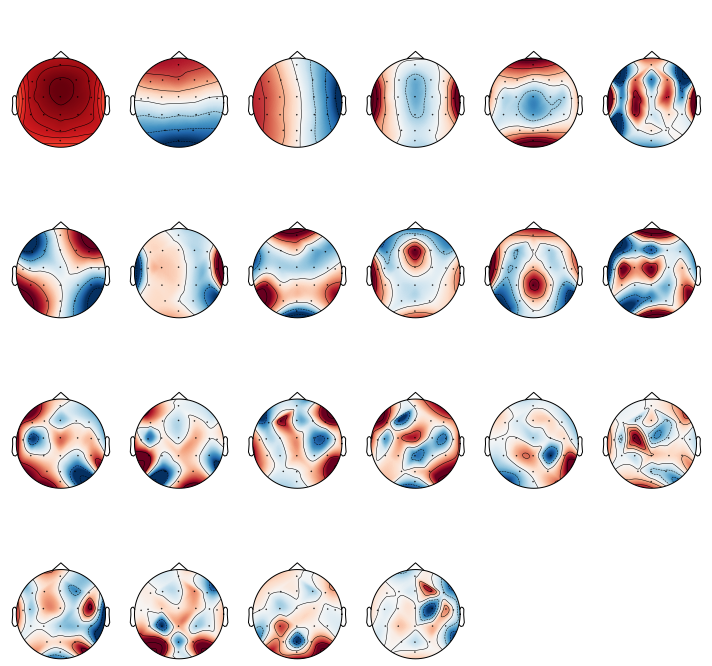

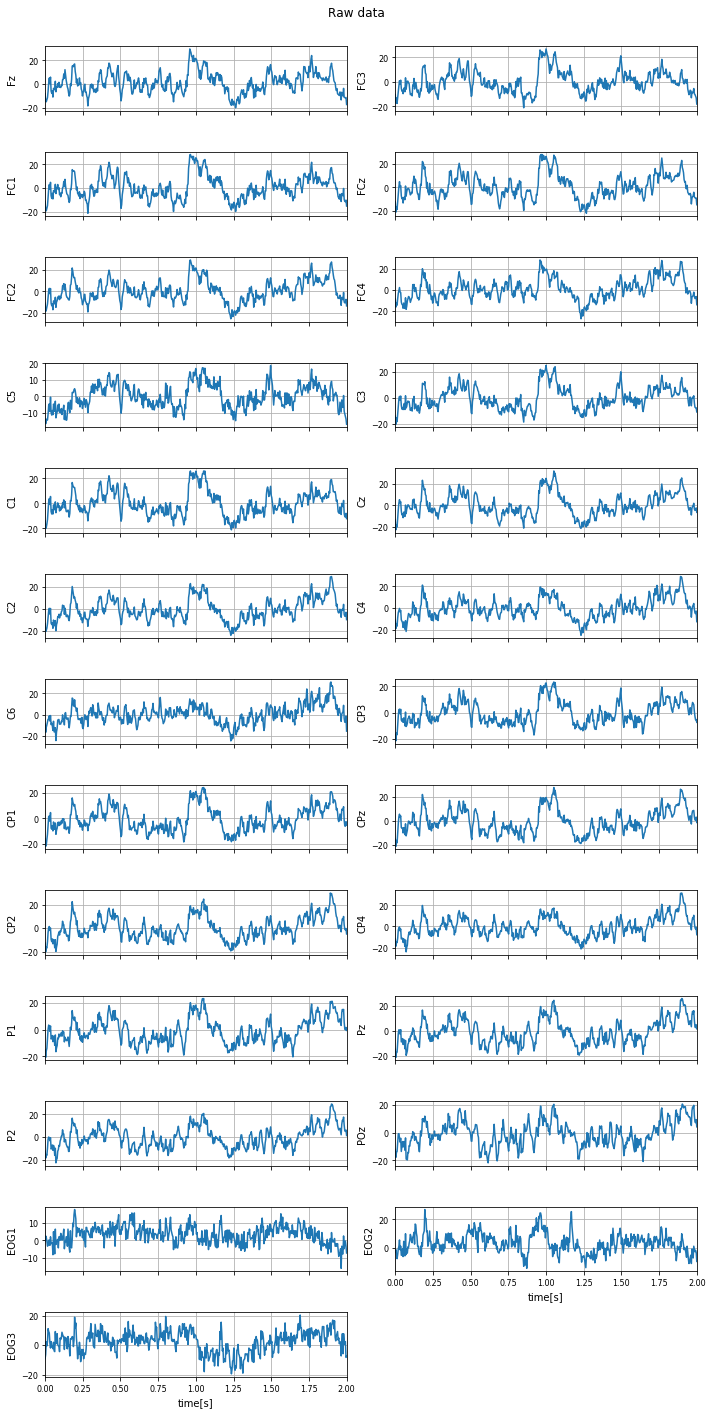

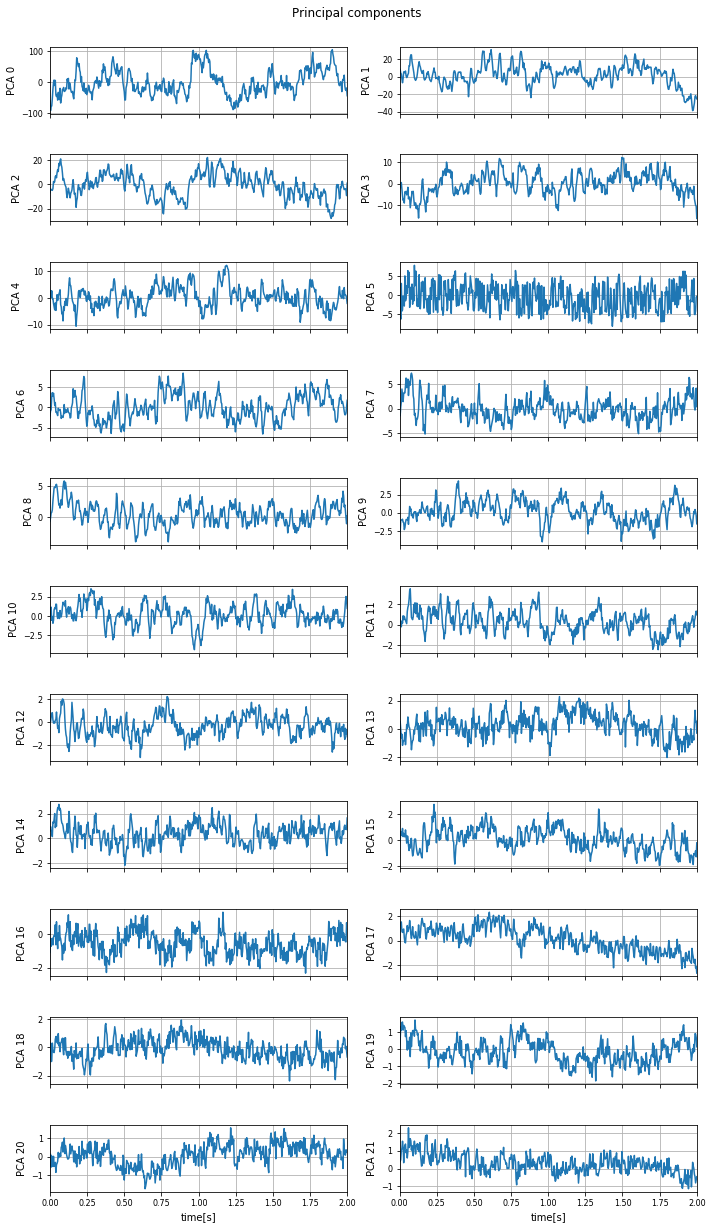

In [60]:
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

#GET DATA
data = spio.loadmat('Datos/DataEEG_EOG_bis.mat')
sampling_freq = data['sf'][0][0]
channel_names = [data['ChannelNames'][i][0][0]for i in range(len(data['ChannelNames']))]
tipos = ['eeg' for i in range(len(channel_names)-3)]+['eog' for i in range(3)]
info = mne.create_info(ch_names = channel_names[:], sfreq = sampling_freq, ch_types = tipos[:], montage = 'standard_1020')
channel_pos = []
for i in range(len(info['chs'])):
    channel_pos.append(info['chs'][i]['loc'][:2])

datos = data['Datos']
datos = np.swapaxes(datos,0,2)
datos_eeg = datos[:,:-3,:]
tiempo = [i/sampling_freq for i in range(len(datos[0][0]))]

#APLICAR PCA
sk_pca = PCA()
pca = UnsupervisedSpatialFilter(sk_pca, average = False)
data_pca = pca.fit_transform(datos_eeg)

#PLOT PRINCIPAL COMPONENTS
W = sk_pca.components_
M = np.linalg.inv(W)
M = M.transpose()

fig = plt.figure(figsize = (10,10))
for i in range(len(M)):
    ax = fig.add_subplot(4,6,i+1)
    ax.set_title('PCA {}'.format(i), color = 'white')
    mne.viz.plot_topomap(M[i], np.array(channel_pos)[:-3], axes = ax, show = False)
fig.tight_layout()
fig.suptitle('Principal components', color = 'white')

#PLOT# RAW DATA AND PRINCIPAL COMPONENTS FOR 1 TRIAL EVERY CHANNEL
fig1 = plt.figure(figsize=(10,20))
fig2 = plt.figure(figsize=(10,20))
for i in range(len(datos[0])):
    ax1 = fig1.add_subplot(13,2,(i+1))
    ax1.grid()
    ax1.set_ylabel('{}'.format(channel_names[i]))
    ax1.plot(tiempo, datos[0][i])
    ax1.set_xlim([0,2])
    ax1.tick_params(axis='both', which='major', labelsize=8)
    if i < len(datos[0])-2:
        ax1.set_xticklabels([])
    else:
        ax1.set_xlabel('time[s]')
fig1.suptitle('Raw data')
fig1.tight_layout(rect = (0, 0, 1, 0.96))

for i in range(len(data_pca[0])):
    ax2 = fig2.add_subplot(13,2,i+1)
    ax2.grid()
    ax2.set_ylabel('PCA {}'.format(i))
    ax2.plot(tiempo, data_pca[0][i])
    ax2.set_xlim([0,2])
    ax2.tick_params(axis='both', which='major', labelsize=8)
    if i < len(data_pca[0])-2:
        ax2.set_xticklabels([])
    else:
        ax2.set_xlabel('time[s]')
fig2.suptitle('Principal components')
fig2.tight_layout(rect = (0, 0, 1, 0.96))

## ICA

Text(0.5, 0.98, 'Independent components')

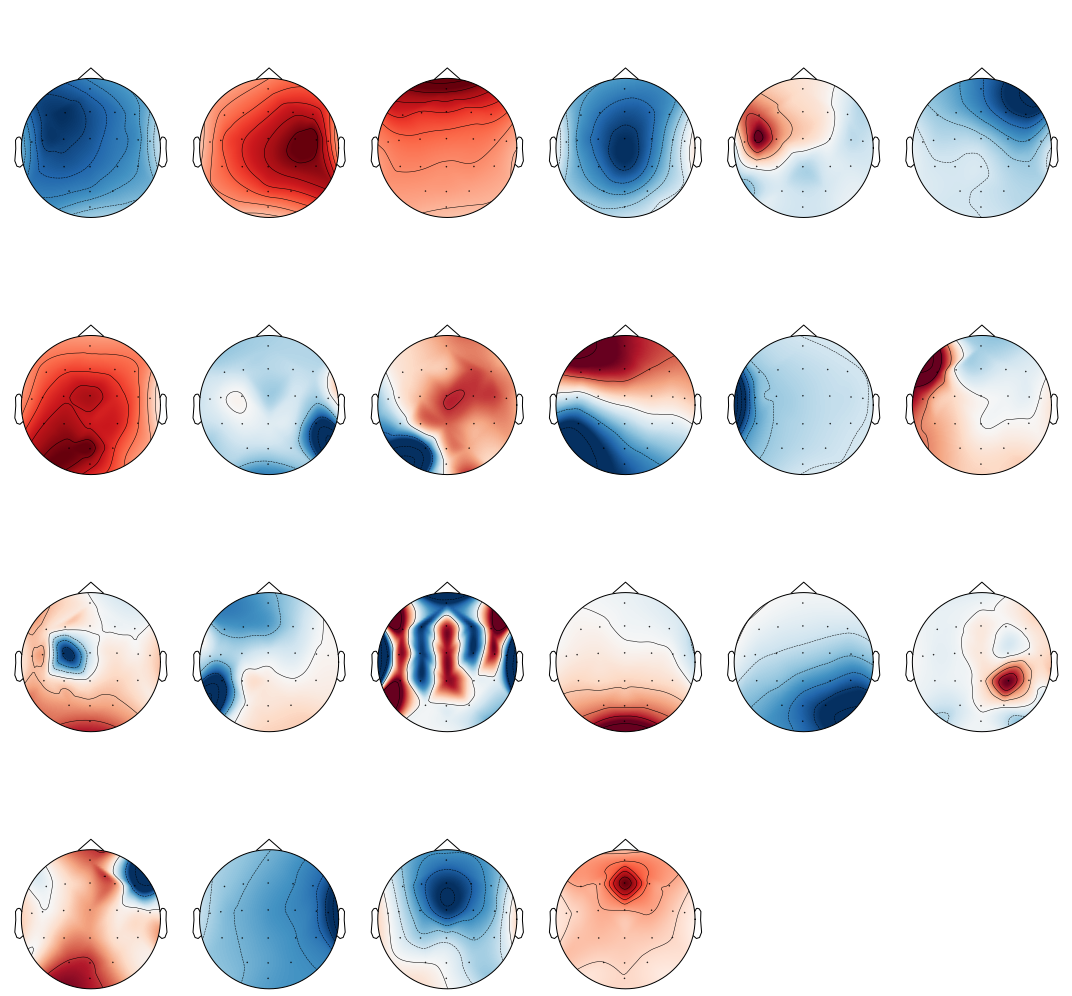

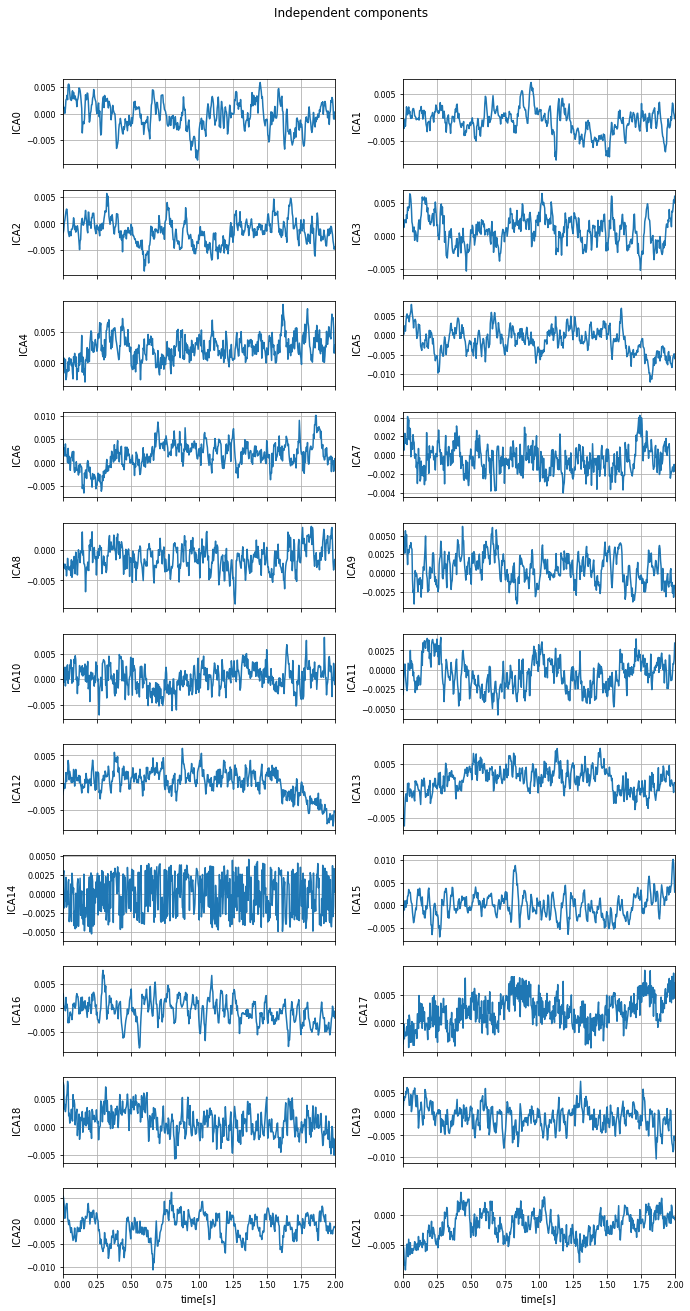

In [80]:
from mne.preprocessing import ICA
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import FastICA

data = spio.loadmat('Datos/DataEEG_EOG_bis.mat')
sampling_freq = data['sf'][0][0]
datos = data['Datos']
datos = np.swapaxes(datos,0,2)
datos_eeg = datos[:,:-3,:]
tiempo = [i/sampling_freq for i in range(len(datos[0][0]))]
channel_names = [data['ChannelNames'][i][0][0]for i in range(len(data['ChannelNames']))]
tipos = ['eeg' for i in range(len(data['ChannelNames'])-3)]+['eog' for i in range(3)]
info = mne.create_info(ch_names = channel_names, sfreq = sampling_freq, ch_types = tipos, montage = 'standard_1020')
channel_pos = []
for i in range(len(info['chs'])):
    channel_pos.append(info['chs'][i]['loc'][:2])

# SKLEARN FASTICA
sk_ica = FastICA(n_components = 22)
ICA_transformer = UnsupervisedSpatialFilter(sk_ica, average = False)
data_ICA = ICA_transformer.fit_transform(datos_eeg)
Mix = sk_ica.mixing_.transpose()

fig = plt.figure(figsize=(15, 15))
for i in range(len(Mix)):
    ax1 = fig.add_subplot(4,6,(i+1))
    ax1.set_title('ICA {}'.format(i), color = 'white', fontsize = 15)
    mne.viz.plot_topomap(Mix[i], np.array(channel_pos)[:-3], axes = ax1, show = False)
fig.tight_layout()
fig.suptitle('Independent components sklearn', color = 'white', fontsize = 20)

###-------- PLOT INDEPENDENT COMPONENTS -------###
fig2 = plt.figure(figsize=(10,20))
plt.subplots_adjust(left = 0.1, bottom=0.1, right=0.95, top=0.93, wspace = 0.25, hspace = 0.3)
for i in range(len(data_ICA[0])):
    ax2 = fig2.add_subplot(11,2,i+1)
    ax2.grid()
    ax2.set_ylabel('ICA{}'.format(i))
    ax2.plot(tiempo, data_ICA[39][i])
    ax2.set_xlim([0,2])
    ax2.tick_params(axis='both', which='major', labelsize=8)
    if (i < len(data_ICA[0])-2):
        ax2.set_xticklabels([])
    else:
        ax2.set_xlabel('time[s]')
fig2.suptitle('Independent components')

Los componentes número 10 y 17 presentan una gran cantidad de ruido (posiblemente de línea sobretodo el 10).
Por otro lado en los mapas topográficos se observan mapas característicos de movimientos musculares (15), de movimientos oculares (5, 11, 18), y de ECG (9). Pero en los gráficos de las señales de dichos canales no permiten asegurar esto mismo, por lo que al eliminarlos se podría estar perdiendo información valiosa. (En general, las componentes de ECG y de parpadeo suelen ser muy fáciles de identificar, presentando picos a una frecuencia determinada y fija, por lo menos en los ejemplos de internet que pude encontrar).

Text(0.5, 0.98, 'Filtered and Raw data')

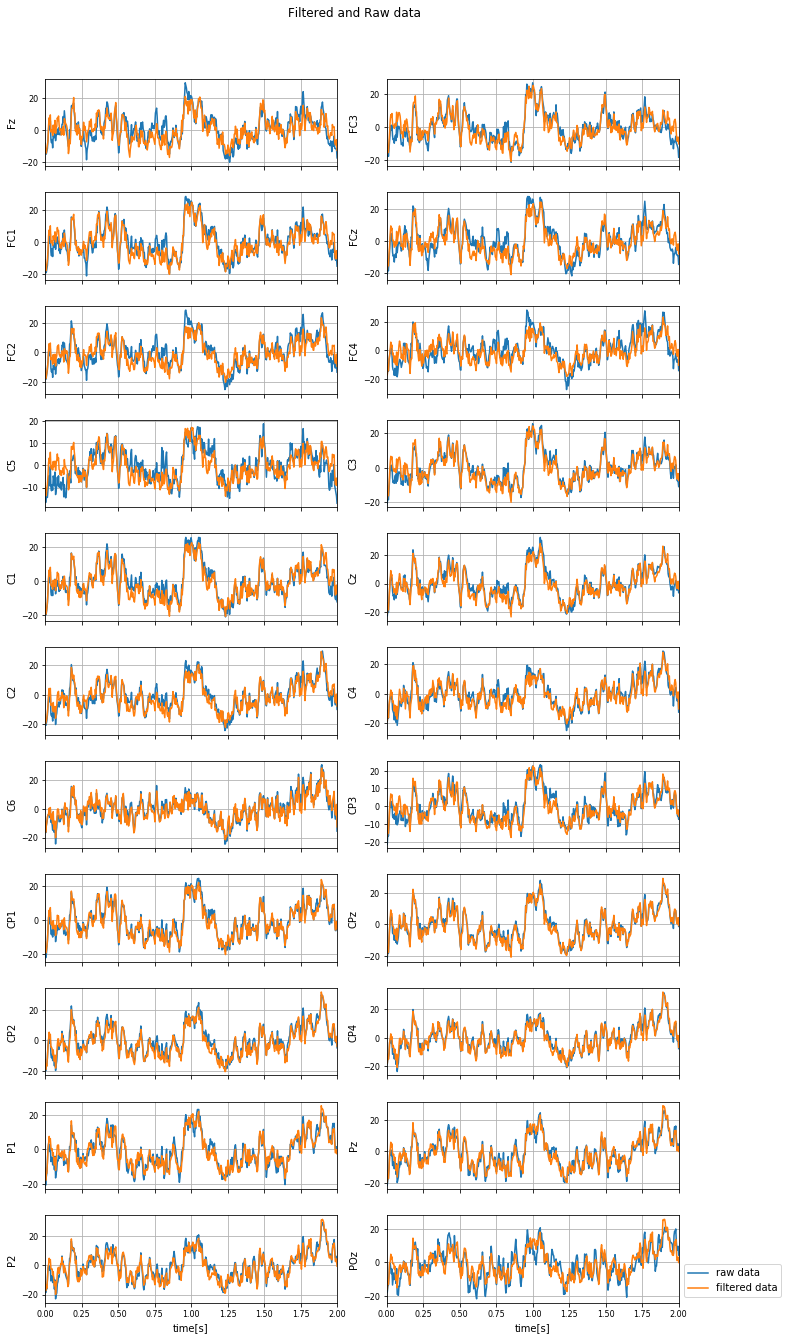

In [93]:
#EXCLUDE ARTIFACTS AND PLOT FILTERED DATA
exclude_channels = [10,17,15,11,5,18]
data_ICA[:, exclude_channels, :] = 0
reconstructed_data = sk_ica.inverse_transform(np.transpose(data_ICA[0])).transpose()

fig1 = plt.figure(figsize=(10,20))
plt.subplots_adjust(left = 0.07, bottom=0.08, right=0.95, top=0.93, wspace = 0.17, hspace = 0.3)
for i in range(len(reconstructed_data)):
    ax1 = fig1.add_subplot(11,2,(i+1))
    ax1.grid()
    ax1.set_ylabel('{}'.format(channel_names[i]))
    ax1.plot(tiempo, datos[0][i], label = 'raw data')
    ax1.plot(tiempo, reconstructed_data[i], label = 'filtered data')
    ax1.set_xlim([0,2])
    ax1.tick_params(axis='both', which='major', labelsize=8)
    if (i < len(reconstructed_data)-2):
        ax1.set_xticklabels([])
    else:
        ax1.set_xlabel('time[s]')
plt.legend(bbox_to_anchor=(1, 0.5))
fig1.suptitle('Filtered and Raw data')

Se eliminan los canales mencionado (igualando las señales de los mismos a 0) y se grafica al data en su espacio original de los electrodos físicos, antes y después del filtrado. Se eliminaron todos los electrodos mencionados con fines demostrativos, ya que eliminando únicamente el 10 y 17, la diferencia antes y después del filtrado es muy poca.

## CSP

288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Computing data rank from raw with rank=None
    Using tolerance 24 (2.2e-16 eps * 22 dim * 4.9e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 24 (2.2e-16 eps * 22 dim * 5e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


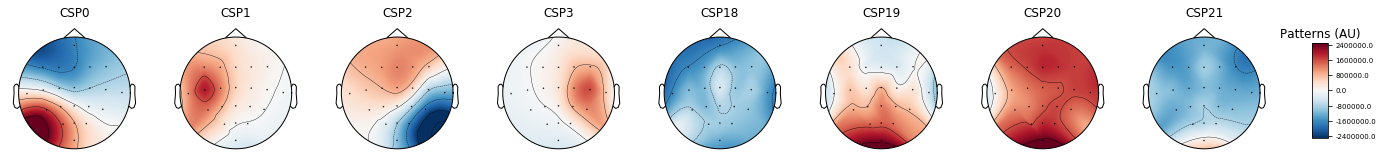

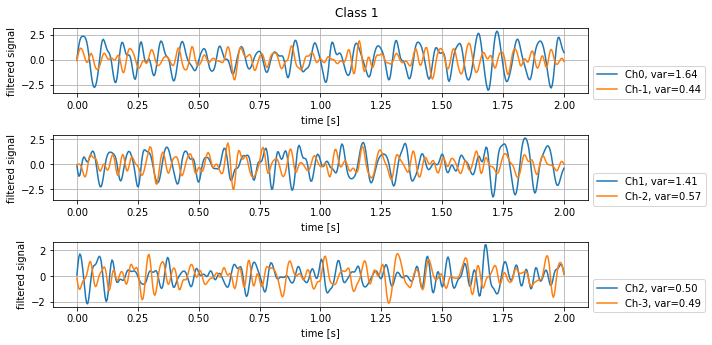

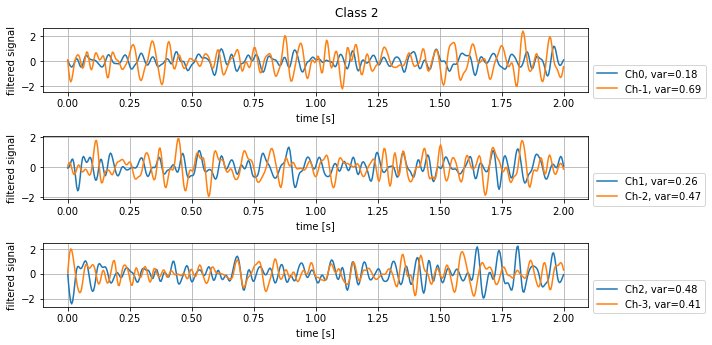

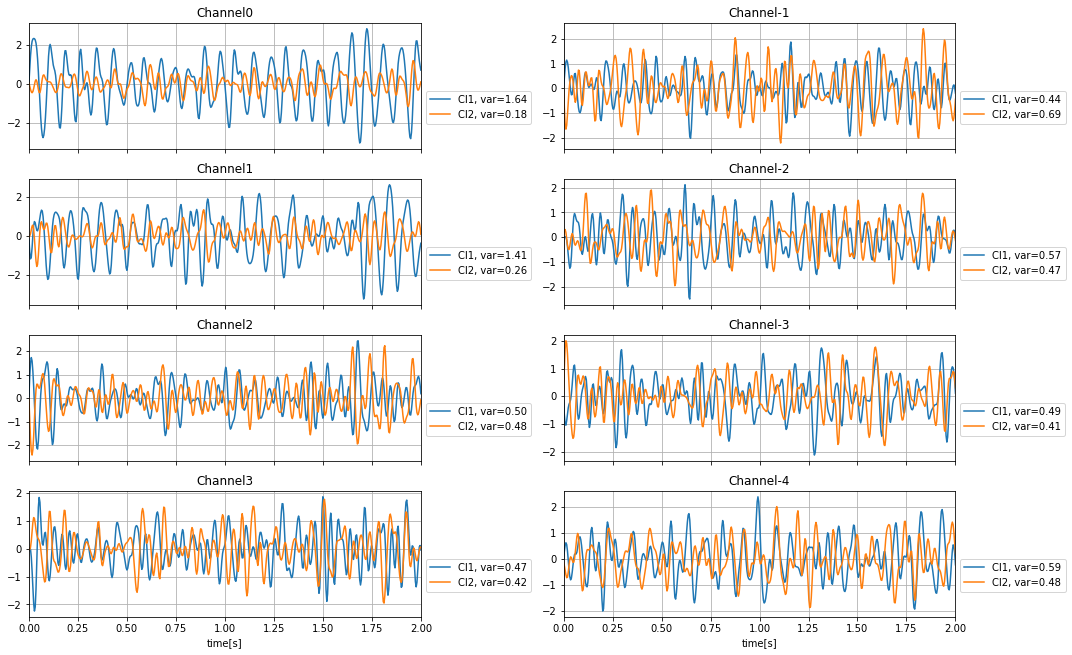

In [3]:
from mne.decoding import CSP

###------- LOAD DATA --------###	
data = spio.loadmat('Datos/DataEEG_EOG_bis.mat')
sampling_freq = data['sf'][0][0]
datos = data['Datos']
datos = np.swapaxes(datos,0,2)
tiempo = [i/sampling_freq for i in range(len(datos[0][0]))]
datos_filt = butter_bandpass_filter(datos, [8, 30], sampling_freq, 2, axis = 2)

labels = data['etiquetas'][0]
channel_names = [data['ChannelNames'][i][0][0]for i in range(len(data['ChannelNames']))]

###----- SET MNE DATA FORMAT -----###
tipos = ['eeg' for i in range(len(channel_names)-3)]+['eog' for i in range(3)]
info = mne.create_info(ch_names = channel_names[:-3], sfreq = sampling_freq, ch_types = tipos[:-3])
eeg = mne.EpochsArray(datos_filt[:,:-3,:], info)
eeg.set_montage('standard_1020')
eeg_temp = eeg.get_data()

###------ CSP ------###
csp = CSP(n_components=22, log=None, transform_into='csp_space')

# plot CSP patterns estimated on full data for visualization
eeg_CSP = csp.fit_transform(eeg_temp, labels)
csp.plot_patterns(eeg.info, components = [0,1,2,3,18,19,20,21], ch_type='eeg', 
                  units='Patterns (AU)', size=1.5)

#GRAFICO LA MISMA CLASE EN LOS 3 PARES DE CANALES PARA VER CAMBIO DE VARIANZA
for i in [2,3]:
    fig = plt.figure(figsize=(10,5))
    fig.suptitle('Class {}'.format(labels[i]))
    k=0
    for j in range(3):
        ax1 = fig.add_subplot(3,1,(j+1))
        ax1.grid()
        ax1.set_xlabel('time [s]')
        ax1.set_ylabel('filtered signal')
        for canal in [0+k, -(1+k)]:
            ax1.plot(tiempo, eeg_CSP[i][canal], label = 'Ch{}, var={:.2f}'.format(canal, np.var(eeg_CSP[i][canal])))
        ax1.legend(bbox_to_anchor=(1,0.5))
        k+=1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])   

# GRAFICO DOS CLASES TRANSFORMADAS PARA VER DISTINTA VARIANZA EN UN MISMO CANAL		
canales = [0,-1,1,-2,2,-3,3,-4]
fig = plt.figure(figsize=(15,10))
k = 1
for j,canal in enumerate(canales):
    ax1 = fig.add_subplot(4, 2, k)
    ax1.grid()
    ax1.set_xlim([0,2])
    ax1.set_title('Channel{}'.format(canal))
    for i in [2,3]:
        plt.plot(tiempo, eeg_CSP[i][canal], label = 'Cl{}, var={:.2f}'.format(labels[i], np.var(eeg_CSP[i][canal])))
    ax1.legend(bbox_to_anchor=(1,0.5))
    k += 1
    if j < len(canales)-2:
        ax1.set_xticklabels([])
    else:
        ax1.set_xlabel('time[s]')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])                      

Text(0.5, 0.98, 'Varianzas por canal')

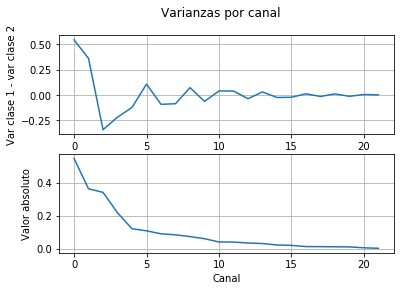

In [4]:
#VEO EL PROMEDIO DE LA VARIANZA DE CADA CLASE PARA CADA CANAL
indexes_1 = get_indexes(labels, 1)
indexes_2 = get_indexes(labels, 2)

varianza_final_1 = []
varianza_final_2 = []
for i in range(len(eeg_CSP[0])):
    var_1 = []
    for index in indexes_1:
        var_1.append(np.var(eeg_CSP[index][i]))	

    var_2 = []
    for index in indexes_2:
        var_2.append(np.var(eeg_CSP[index][i]))

    varianza_final_1.append(np.mean(var_1))
    varianza_final_2.append(np.mean(var_2))

dif_var = [varianza_final_1[i]-varianza_final_2[i] for i in range(len(varianza_final_1))]

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.plot(dif_var)
ax.grid()
ax.set_ylabel('Var clase 1 - var clase 2')
ax1 = fig.add_subplot(2,1,2)
ax1.plot(abs(np.array(dif_var)))
ax1.grid()
ax1.set_xlabel('Canal')
ax1.set_ylabel('Valor absoluto')
fig.suptitle('Varianzas por canal')

288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Computing data rank from raw with rank=None
    Using tolerance 17 (2.2e-16 eps * 22 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using SHRINKAGE
Done.
Computing data rank from raw with rank=None
    Using tolerance 17 (2.2e-16 eps * 22 dim * 3.5e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using SHRINKAGE
Done.
288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Computing data rank from raw with rank=None
    Using tolerance 14 (2.2e-16 eps * 22 dim * 2.9e+15  max singular value)
    Estimated rank (mag): 22
    MAG: ra

/home/joaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/home/joaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/home/joaco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide


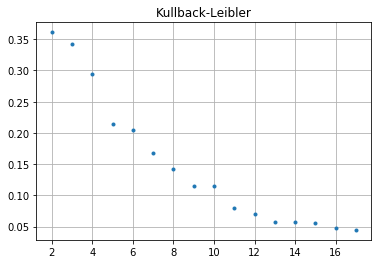

features_discriminantes = [4, 11, 6, 9, 16, 5, 7, 15, 3, 10, 1]


In [9]:
from mne.decoding import CSP

data = spio.loadmat('Datos/DataEEG_EOG_bis.mat')
sampling_freq = data['sf'][0][0]
datos = data['Datos']
tiempo = [i/sampling_freq for i in range(len(datos[0][0]))]
datos = np.swapaxes(datos,0,2)

datos_filt = {}
frecuencias = [[4,8], [8, 12], [13, 30]]
for frecuencia in frecuencias:
    datos_filt[str(frecuencia)] = butter_bandpass_filter(datos, frecuencia, sampling_freq, 2, axis = 2)

labels = data['etiquetas'][0]
channel_names = [data['ChannelNames'][i][0][0]for i in range(len(data['ChannelNames']))]

features = []
###----- SET MNE DATA FORMAT -----###
for frecuencia  in range(len(frecuencias)):
    tipos = ['eeg' for i in range(len(channel_names)-3)]+['eog' for i in range(3)]
    info = mne.create_info(ch_names = channel_names[:-3], sfreq = sampling_freq, ch_types = tipos[:-3])
    eeg = mne.EpochsArray(datos_filt[str(frecuencias[frecuencia])][:,:-3,:], info)
    eeg.set_montage('standard_1020')
    eeg_temp = eeg.get_data()

###------ CSP CON AVERAGE POWER Y LO -> QUE DEVUELVE LAS FEATURES EN VEZ DE LOS Z------###
    csp = CSP(n_components=22, reg=0.5, log=True, transform_into='average_power')
    eeg_CSP = csp.fit_transform(eeg_temp, labels)

###---- ME QUEDO LOS PRIMEROS Y UTIMOS 3 CANALES QUE SON LAS FEATURES QUE MAS DIFERENCIAN LAS CLASES---###
    for i in range(len(eeg_CSP)):
        features.append(np.concatenate((eeg_CSP[i,:3], eeg_CSP[i,-3:])))

###---- ARMO LA LISTA DE FEATURES FINAL DE 18 P CADA TRIAL ----###
features_final = []
for i in range(len(eeg_CSP)):
    features_final.append(np.concatenate((features[i], features[i+288], features[i+2*288])))

###----ARMO HISTOGRAMAS PARA HACER KULLBACK ----###
indexes_1 = get_indexes(labels, 1)
indexes_2 = get_indexes(labels, 2)

features_final = np.transpose(np.array(features_final))

hist_1 = []
edges_1 = []
hist_2 = []
edges_2 = []
for i in range(len(features_final)):
    hist, edges = np.histogram(features_final[i][indexes_1], bins = 12, density = True)
    hist_1.append(hist)
    edges_1.append(edges)
    hist, edges = np.histogram(features_final[i][indexes_2], bins = 12, density = True)
    hist_2.append(hist)
    edges_2.append(edges)

Kullback = []
for i in range(len(hist_1)):
    p = hist_1[i]*np.diff(edges_1[i])
    q = hist_2[i]*np.diff(edges_2[i])
    Kullback.append([i,kl(p,q)])

Kullback.sort(key = operator.itemgetter(1), reverse = True)
        
plt.figure()
plt.grid()
plt.title('Kullback-Leibler')
plt.plot([Kullback[i][1]for i in range(len(Kullback))], '.')
plt.show()

# CONSERVO LAS FEATURES QUE ME DAN UNA DIFERENCIA ENTER CLASES MAYOR A 0.1 SEGUN KULLBACK
features_discriminantes = []
i=0
while(Kullback[i][1]>0.1):
    features_discriminantes.append(Kullback[i][0])
    i+=1

print('features_discriminantes = {}'.format(features_discriminantes))

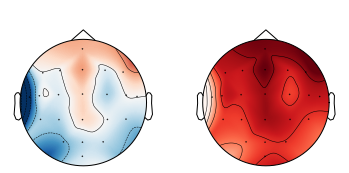

In [10]:
###------- LOAD DATA --------###	
data = spio.loadmat('Datos/DataEEG_EOG_bis.mat')
#locations = spio.loadmat('Datos/EMapAll.mat')
#locations = locations['EMapAll']
sampling_freq = data['sf'][0][0]
datos = data['Datos']
datos = np.swapaxes(datos,0,2)
tiempo = [i/sampling_freq for i in range(len(datos[0][0]))]
labels = data['etiquetas'][0]

###---- SELECT TRIAL FOR PLOTTING THEN FILTER TRIAL IN FRECUENCIES AND CAR ----###
trial_1 = np.transpose(datos[0, :, :])
trial_1_CAR = np.array(np.transpose(datos[0, :, :]))

for i in range(len(trial_1_CAR)):
    promedio = np.mean(trial_1_CAR[i])
    for j in range(len(trial_1_CAR[i])):
        trial_1_CAR[i,j] -= promedio

###---- SET MNE DATA FORMAT ----###
channel_names = [data['ChannelNames'][i][0][0]for i in range(len(data['ChannelNames']))]
tipos = ['eeg' for i in range(len(channel_names)-3)]+['eog' for i in range(3)]
info = mne.create_info(ch_names = channel_names[:], sfreq = sampling_freq, ch_types = tipos[:], montage = 'standard_1020')
channel_pos = []
for i in range(len(info['chs'])):
	channel_pos.append(info['chs'][i]['loc'][:2])

###---- PLOT EEG RAW DATA OVER 1 TRIAL ----###
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

for i in range(50):
    ax1.clear()
    ax2.clear()
    ax1.set_title('Trial 1 - CAR EEG data', color = 'white')
    mne.viz.plot_topomap(trial_1_CAR[i][:-3], np.array(channel_pos[:-3]), axes = ax1, show = False)
    ax2.set_title('Trial 1 - RAW EEG data', color = 'white')
    mne.viz.plot_topomap(trial_1[i][:-3], np.array(channel_pos[:-3]), axes = ax2, show = False)
    display(fig1)
    clear_output(wait = True)  